In [1]:
import sys
quic_path = '/home/quic/QUIC-Projects'
if not quic_path in sys.path:
    sys.path.append(quic_path)

In [2]:
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
# for SVM
from classifiers.convex.svm import BinarySVM
from classifiers.kernel import Kernel
from classifiers.datasets import IrisDataset
# for QASVM
from classifiers.quantum.qasvm import SoftQASVM, PseudoSoftQASVM
from classifiers.convex.svm import CvxSoftQASVM
from classifiers.quantum.ansatz import Circuit9, sample_circuit
from classifiers.callback import CostParamStorage
from qiskit.utils import QuantumInstance
from qiskit.providers.aer import AerSimulator, StatevectorSimulator, Aer, QasmSimulator
# for optimization
from qiskit.algorithms.optimizers import SPSA, ADAM
from tqdm.notebook import tqdm

In [4]:
iris_dataset = IrisDataset(feature_range=(-np.pi, np.pi))
iris_data, iris_label, iris_names, iris_features = iris_dataset.data, iris_dataset.target, iris_dataset.target_names, iris_dataset.feature_names

classes = list(iris_names)
ds = {__l:IrisDataset(feature_range=(-np.pi, np.pi), true_hot=__l) for __l in classes}
training_set = IrisDataset(feature_range=(-np.pi, np.pi)).sample(2**6, random_state = 83495)
trainind_data = training_set[training_set.columns[0:-2]].to_numpy()
training_labels = {__l: ds[__l].frame.iloc[training_set.index].target.to_numpy() for __l in classes}

In [5]:
backend = StatevectorSimulator(device='CPU', shots=2**13)
backend.options

Options(shots=8192, device='CPU', precision='double', executor=None, max_job_size=None, max_shot_size=None, zero_threshold=1e-10, validation_threshold=None, max_parallel_threads=None, max_parallel_experiments=None, max_parallel_shots=None, max_memory_mb=None, seed_simulator=None, fusion_enable=True, fusion_verbose=False, fusion_max_qubit=5, fusion_threshold=14, statevector_parallel_threshold=14)

In [6]:
_feature_map = Circuit9(4, reps=1)
feature_map = _feature_map.copy()
for _ in range(2 - 1):
    feature_map.compose(_feature_map, inplace=True)

var_form = sample_circuit(15)(num_qubits=6, reps=5)
quantum_instance = QuantumInstance(backend=backend, shots=2**13)

MAXITER = 2**13

In [7]:
label_index = 0

from tqdm.notebook import tqdm
from itertools import product

from sklearn.svm import SVC
__qasvm = PseudoSoftQASVM(
        trainind_data, training_labels['setosa'], lamda=1, C=10,
        quantum_instance=quantum_instance,
        var_form=None,
        feature_map=feature_map
    )
kernel_matrix = __qasvm.kernel_matrix
hyperC = 10**np.linspace(-4, 4, 5)
lamdas = 10**np.linspace(-4, 4, 5)
X, Y = np.meshgrid(hyperC, lamdas)
Z = np.empty_like(X)

In [8]:
with tqdm(total = len(X.flatten())) as pbar:
    for i, _X in enumerate(X):
        for j, _ in enumerate(_X):
            svm = SVC(C=X[i, j], kernel='precomputed')
            svm.fit(kernel_matrix+1/Y[i, j], np.where(training_set['target'].to_numpy()==label_index, 1, 0))
            accuracy = svm.score(__qasvm._qk.evaluate(iris_data, trainind_data)+1/Y[i, j], np.where(iris_label==label_index, 1, 0))
            Z[i, j] = accuracy
            pbar.update()

  0%|          | 0/25 [00:00<?, ?it/s]

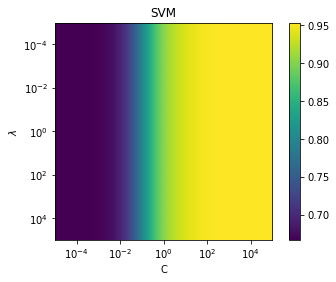

In [9]:
fig, ax = plt.subplots()
cs = ax.imshow(Z, interpolation='gaussian')
ax.set_xlabel('C')
ax.set_ylabel(r'$\lambda$')
ax.set_xticks(np.arange(len(hyperC)))
ax.set_xticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(hyperC))))
ax.set_yticks(np.arange(len(lamdas)))
ax.set_yticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(lamdas))))
ax.set_title('SVM')
fig.colorbar(cs)

In [10]:
Z_ = np.empty_like(Z)
with tqdm(total = len(X.flatten())) as pbar:
    def callback(*args):
        pass
    for i, _X in enumerate(X):
        for j, _ in enumerate(_X):
            qasvm = CvxSoftQASVM(kernel='precomputed', C=X[i, j], lamda=Y[i, j])
            qasvm.fit(kernel_matrix, np.where(training_set['target'].to_numpy()==label_index, 1, 0))
            accuracy = qasvm.score(__qasvm._qk.evaluate(iris_data, trainind_data), np.where(iris_label==label_index, 1, 0))
            Z_[i, j] = accuracy
            pbar.update()

  0%|          | 0/25 [00:00<?, ?it/s]

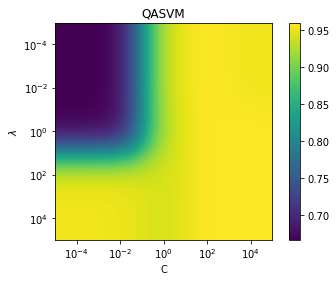

In [11]:
fig, ax = plt.subplots()
cs = ax.imshow(Z_, interpolation='gaussian')
ax.set_xlabel('C')
ax.set_ylabel(r'$\lambda$')
ax.set_xticks(np.arange(len(hyperC)))
ax.set_xticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(hyperC))))
ax.set_yticks(np.arange(len(lamdas)))
ax.set_yticklabels(list(map(r'$10^{{{:1.0f}}}$'.format, np.log10(lamdas))))
ax.set_title('QASVM')
fig.colorbar(cs)

In [12]:
layers = np.arange(1, 21, 2)
var_forms = [sample_circuit(15)(num_qubits=6, reps=_r) for _r in layers]
accuracy_list = []
num_params_list = []
last_cost_list = []

for i, layer in enumerate(tqdm(layers)):
    qasvm = PseudoSoftQASVM(
        data=trainind_data, label=np.where(training_set['target'].to_numpy()==label_index, 1, 0),
        quantum_instance=quantum_instance,
        feature_map=feature_map,
        var_form=var_forms[i],
        lamda=10**4, C=10
    )
    with tqdm(total=2**10) as pbar:
        pbar.set_description(f'layer: {layer}')
        def callback(*args):
            pbar.update()
        optimzer = SPSA(maxiter=2**10, blocking=True, callback=callback)
        result = optimzer.minimize(qasvm.cost_fn, qasvm.initial_point)
    qasvm.parameters = result.x
    accuracy = qasvm.accuracy(iris_data, np.where(iris_label==label_index, 1, 0))
    accuracy_list.append(accuracy)
    num_params_list.append(qasvm.num_parameters)
    last_cost_list.append(result.fun)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

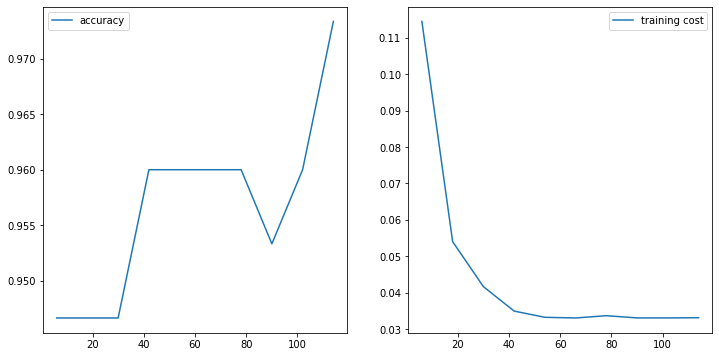

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(num_params_list, accuracy_list, label='accuracy')
axes[1].plot(num_params_list, last_cost_list, label='training cost')
axes[0].legend()
axes[1].legend()

In [14]:
layers = np.arange(1, 21, 2)
var_forms = [sample_circuit(9)(num_qubits=6, reps=_r) for _r in layers]
_accuracy_list = []
_num_params_list = []
_last_cost_list = []

for i, layer in enumerate(tqdm(layers)):
    qasvm = PseudoSoftQASVM(
        data=trainind_data, label=np.where(training_set['target'].to_numpy()==label_index, 1, 0),
        quantum_instance=quantum_instance,
        feature_map=feature_map,
        var_form=var_forms[i],
        lamda=10**4, C=10
    )
    with tqdm(total=2**10) as pbar:
        pbar.set_description(f'layer: {layer}')
        def callback(*args):
            pbar.update()
        optimzer = SPSA(maxiter=2**10, blocking=True, callback=callback)
        result = optimzer.minimize(qasvm.cost_fn, qasvm.initial_point)
    qasvm.parameters = result.x
    accuracy = qasvm.accuracy(iris_data, np.where(iris_label==label_index, 1, 0))
    _accuracy_list.append(accuracy)
    _num_params_list.append(qasvm.num_parameters)
    _last_cost_list.append(result.fun)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

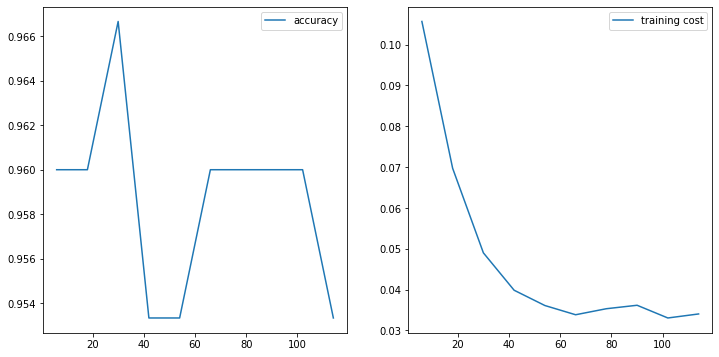

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(_num_params_list, _accuracy_list, label='accuracy')
axes[1].plot(_num_params_list, _last_cost_list, label='training cost')
axes[0].legend()
axes[1].legend()

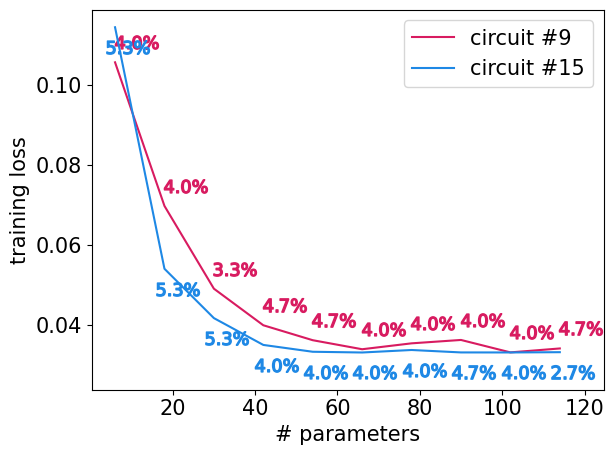

In [80]:
import matplotlib
matplotlib.rcParams['font.size'] = 15

plt.plot(_num_params_list, _last_cost_list, label='circuit #9', color='#D81B60')
for _x, _y, _a in zip(_num_params_list, _last_cost_list, _accuracy_list):
    plt.scatter([_x+5], [_y+0.005], marker="${:.1%}$%".format(1-_a), c='#D81B60', s=1000)

plt.plot(num_params_list, last_cost_list, label='circuit #15', color='#1E88E5')
for _x, _y, _a in zip(num_params_list, last_cost_list, accuracy_list):
    plt.scatter([_x+3], [_y-0.005], marker="${:.1%}$%".format(1-_a), c='#1E88E5', s=1000)
plt.xlabel("# parameters")
plt.ylabel("training loss")
plt.legend()
plt.tight_layout()

In [71]:
accuracy_list[0]

0.9466666666666667